## Assignment 1 - Group 26 - Naive Approaches

For this assignment the Movielens dataset with 1 million records is used.

In this notebook 4 naive approaches are implemented in an attempt to find a low error rate in the form of Root Mean Square Error.

First we import the necessary packages, set the seed and load the data.

In [88]:
# import packages
import numpy as np
np.warnings.filterwarnings('ignore')
import pandas as pd
import random
import time 
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
random.seed(26)


In [89]:
# load the users, ratings and movies
users = pd.read_csv("ml-1m/users.dat", sep = "::", engine = "python", header = None)
ratings = pd.read_csv("ml-1m/ratings.dat", sep = "::", engine = "python", header = None)
ratings.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies = pd.read_csv("ml-1m/movies.dat", sep = "::", engine = "python", header = None)

# create a dataframe with items and then sort
ratings_df = ratings[['MovieID', 'Rating']]
ratings_df = ratings_df.sort_values(by = ['MovieID'])

# create a dataframe with users
users_df = ratings[['UserID', 'Rating']]


Instead of writing the code for all 4 approaches in one big block, the code is separated into different methods for readability and efficiency.

In [90]:
# method to calculate the Root Mean Square Error with 2 inputs
def RootMeanSquare(predicted, actual):
    return np.sqrt(sum((predicted - actual) ** 2) / len(actual))

In [91]:
# naive method 1, get the mean of all ratings
def R_global(data, columnname = 'Rating'):
    return np.mean(data[columnname])

In [92]:
# naive method 2, get the mean of all ratings for that particular item
def R_item(data, columnname = 'MovieID'):
    # group by and get the means, now it's in a short format
    grouped = data.groupby(columnname, as_index = False).mean()
    return grouped

In [93]:
# naive method 3, get the mean of all ratings for that particular user
def R_user(data, columnname = 'UserID'):
    # group by and get the means, now it's in a short format
    grouped = data.groupby(columnname, as_index = False).mean()
    return grouped

Now we have defined the error function as well as the first 3 naive approaches. Next up we define the CrossValidation function where we split the data into 5 folds.

In [94]:
# crossvalidation method that trains the data, crossvalidates and calculates the error
def CrossValidation(model_function, data, RootMeanSquare_function = RootMeanSquare, return_df = False):
    
    # keep track of the duration of the computations
    start_time = time.time()
    
    # shuffle the data
    data = data.sample(frac = 1)
    
    # 5-fold crossvalidation, get the indices for the folds
    splice_number = int(len(data) / 5)
    fold_1 = 0
    fold_2 = splice_number * 1
    fold_3 = splice_number * 2
    fold_4 = splice_number * 3
    fold_5 = splice_number * 4
    
    # create the folds
    test_1 = data.iloc[range(fold_1, fold_2)] # fold 1 as testset
    test_2 = data.iloc[range(fold_2, fold_3)] # fold 2 as testset
    test_3 = data.iloc[range(fold_3, fold_4)] # fold 3 as testset
    test_4 = data.iloc[range(fold_4, fold_5)] # fold 4 as testset
    test_5 = data.iloc[range(fold_5, len(data))]
       
    # train sets are combination of folds that are not the testset
    train_1 = data.iloc[range(fold_2, len(data))]
    train_2 = pd.concat([test_1, test_3, test_4, test_5])
    train_3 = pd.concat([test_1, test_2, test_4, test_5])
    train_4 = pd.concat([test_1, test_2, test_3, test_5])
    train_5 = data.iloc[range(fold_1, fold_5)]
    
    # put the folds into a list so that they can be looped over
    test_list = [test_1, test_2, test_3, test_4, test_5]
    train_list = [train_1, train_2, train_3, train_4, train_5]
    
    # initialize result lists
    RMSE_list = [0] * len(train_list)
    
    # apply the function to 4 folds and train, then test on the other, do this for all combinations
    # loop over the train sets
    if model_function == R_global:
        
        for i in range(len(test_list)): 
            # get the predicted values
            predicted = model_function(train_list[i])
            
            # get the error
            RMSE_list[i] = RootMeanSquare_function(predicted = predicted, actual = test_list[i]['Rating'])
            
        # get the ending time
        end_time = time.time()
        return([np.mean(RMSE_list), (end_time - start_time)])
    
   # loop looks differently for the other naive methods
    else:
        # initialize a list in which the dataframes will be put
        merged_dfs = [0] * len(train_list)
        
        for i in range(len(train_list)):
            predicted = model_function(train_list[i])
            
            # different columnname for different function
            if model_function == R_item:
                columnname = 'MovieID'
            elif model_function == R_user:
                columnname = 'UserID'

            # rename column from rating to predicted as these are now the predicted values
            predicted.rename(columns = {'Rating' : 'Predicted'}, inplace = True)
            
            # merge the test dataframe with the predicted dataframe (which contains the predicted values)
            merged = pd.merge(test_list[i], predicted, how = 'left', on = columnname)
            # drop na values that occur because some items/users are not present in either
            merged = merged.dropna()
            
            # add this to a list in case we want to return it (for the regression)
            merged_dfs[i] = merged 
            
            # now we get the error
            RMSE_list[i] = RootMeanSquare_function(predicted = merged['Predicted'], actual = merged['Rating'])
    
        # get the ending time
        end_time = time.time()
        # return df option needed for linear regression
        return([np.mean(RMSE_list), (end_time - start_time), merged_dfs])



Before we run the CrossValidation method for the first three naive approaches we define the 4th final approach, the LinearRegression method. This method takes the dataframes from the 2nd and 3rd approaches (already shuffled and k-folded) rather than redoing the computations.

In [95]:
# naive method 4, get the means of the items and users respectively, plug those into a regression formula
def R_LinearRegression(R_item_data, R_user_data):
    
    start_time = time.time()
    
    # initialize result list
    RMSE_list = [0] * len(R_item_data)

    # loop over the different folds
    for i in range(len(R_item_data)):
        
        # get the current dataframes, easy to do operations on without additional indexing
        R_item_current = R_item_data[i]
        R_user_current = R_user_data[i]
        # remove unnecessary merged columns
        R_item_current = R_item_current[['UserID_x', 'MovieID', 'Rating', 'Predicted']]
        R_user_current = R_user_current[['UserID', 'MovieID_x', 'Rating', 'Predicted']]
        # rename columns for merging
        R_item_current.rename(columns = {'UserID_x' : 'UserID', 'Predicted' : 'Predicted_item_based'}, inplace = True)
        R_user_current.rename(columns = {'MovieID_x' : 'MovieID', 'Predicted' : 'Predicted_user_based'}, inplace = True)
        
        # merge
        merged = pd.merge(R_item_current, R_user_current, how = 'left', on = ['UserID', 'MovieID'])
        # the merge will create a dataframe with many NaN values, makes sense since some users/items are not in the other dataframe
        merged = merged.dropna()

        # get our variables for the regression
        R_item = merged['Predicted_item_based']
        R_user = merged['Predicted_user_based']
        # put them in a matrix with an intercept
        X = np.vstack([R_item, R_user, np.ones(len(R_item))]).T
        y = merged['Rating_x'] # doesn't matter whether we pick the rating_x or rating_y from the dataframe, they are equal (proven)
        
        # run the regression
        S = np.linalg.lstsq(X,y)
        
        # S[1] contains the sum of squared residuals, so now we only need to divide by n and take the sqrt
        RMSE_list = np.sqrt(S[1] / len(R_item))
        
        # get the ending time
        end_time = time.time()
        
    return([np.mean(RMSE_list), (end_time - start_time)])


Now we can run the CrossValidation method for all 4 naive approaches. Since we're reusing the dataframes generated by the 2nd and 3rd methods for the 4th method (linear regression), the total computation time for the regression method is equal to the computation time of the 2nd + 3rd and 4th.

In [96]:
R_global_results, total_time_global = CrossValidation(R_global, ratings[['MovieID', 'Rating']])
print('The Average RMSE on the test set of the Global Mean approach, averaged over 5 different folds, is equal to: ', R_global_results, '\n', 'This method took: ', total_time_global, ' seconds.')
R_item_results, total_time_item, R_item_df_list = CrossValidation(R_item, ratings)
print('The Average RMSE on the test set of the Movie Mean approach, averaged over 5 different folds, is equal to: ', R_item_results, '\n', 'This method took: ', total_time_item, ' seconds.')
R_user_results, total_time_user, R_user_df_list = CrossValidation(R_user, ratings)
print('The Average RMSE on the test set of the User Mean approach, averaged over 5 different folds, is equal to: ', R_user_results, '\n', 'This method took: ', total_time_user, ' seconds.')
R_regression_results, total_time_regression = R_LinearRegression(R_item_df_list, R_user_df_list)
print('The Average RMSE on the test set of the Regression approach, averaged over 5 different folds, is equal to: ', R_regression_results, '\n', 'This method took: ', total_time_item + total_time_user + total_time_regression, ' seconds. \n')
print('The regression calculations (excluding the Movie/User Mean computation times) took: ', total_time_regression)

The Average RMSE on the test set of the Global Mean approach, averaged over 5 different folds, is equal to:  1.117100815433041 
 This method took:  0.4828026294708252  seconds.
The Average RMSE on the test set of the Movie Mean approach, averaged over 5 different folds, is equal to:  0.9792654593134344 
 This method took:  0.9664146900177002  seconds.
The Average RMSE on the test set of the User Mean approach, averaged over 5 different folds, is equal to:  1.0355078761213214 
 This method took:  0.9575314521789551  seconds.
The Average RMSE on the test set of the Regression approach, averaged over 5 different folds, is equal to:  0.9254276785897628 
 This method took:  2.4502594470977783  seconds. 

The regression calculations (excluding the Movie/User Mean computation times) took:  0.526313304901123


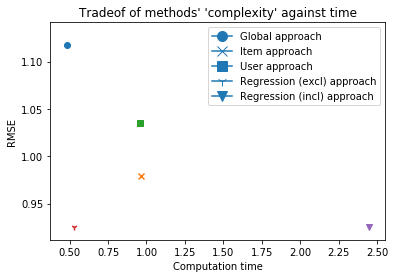

In [97]:
# plot the data
fig = plt.figure()
ax = fig.gca()
# different markers for the approaches
ax.scatter(total_time_global, R_global_results, marker = 'o')
ax.scatter(total_time_item, R_item_results, marker = 'x')
ax.scatter(total_time_user, R_user_results, marker = 's')
ax.scatter(total_time_regression, R_regression_results, marker = '1')
ax.scatter((total_time_item + total_time_user + total_time_regression), R_regression_results, marker = 'v')


plt.xlabel('Computation time')
plt.ylabel('RMSE')
plt.title("Tradeof of methods' 'complexity' against time")
# add legend for markers
global_mark = mlines.Line2D([], [], marker='o', markersize=10, label='Global approach')
item_mark = mlines.Line2D([], [], marker='x', markersize=10, label='Item approach')
user_mark = mlines.Line2D([], [], marker='s', markersize=10, label='User approach')
reg_mark = mlines.Line2D([], [], marker='1', markersize=10, label='Regression (excl) approach')
tot_reg_mark = mlines.Line2D([], [], marker='v', markersize=10, label='Regression (incl) approach')

plt.legend(handles=[global_mark, item_mark, user_mark, reg_mark, tot_reg_mark])
plt.show()
#plt.plot([total_time_global, total_time_item, total_time_user, total_time_item + total_time_user + total_time_regression], [R_global_results, R_item_results, R_user_results, R_regression_results], 'ro')

From the results as well as the simple graph it is clear that the global mean can be easily and hastily computed, though its results are not too favourable with an RMSE of ~1.12

Interestingly, we expected that the 3rd naive approach (the mean of the ratings based on the userID) would yield a better RMSE than the 1st and 2nd naive approaches. The results indicate that taking the mean based on all of the items and using that as a predictor works best out of the first 3 approaches.

The best working approach turns out to be the regression approach. In the graph 2 points indicate the regression approach's results. The (excl) denotes the computation time for just the regression calculation whereas the (incl) also includes the time it takes to compute the Item and the User approaches, which are both used in the regression approach. The regression computation itself is very quick ~0.53 seconds but the computations of the item and user approach inflate the total regression computation to ~2.57 seconds.

In conclusion, the Linear Regression approach has the best performance based on RMSE minimization.

